In [ ]:
# Ch17-3 Image Analysis

In [ ]:
# Install Tools #
! pip install scikit-image

Creating synthetic cell image...
=== CELL IMAGE ANALYSIS ===

Image dimensions: (200, 200)
Pixel value range: 0 - 255
Mean intensity: 53.91

1. COMPONENT SEGMENTATION
------------------------------
Background  : 14555 pixels (36.39%)
Cytoplasm   : 18762 pixels (46.91%)
ER          :   972 pixels ( 2.43%)
Mitochondria:   778 pixels ( 1.94%)
Nucleus     :  2894 pixels ( 7.23%)
Membranes   :  2039 pixels ( 5.10%)

2. MORPHOLOGICAL ANALYSIS
------------------------------
Nucleus area: 2894.0 pixels
Nucleus centroid: (95.4, 108.9)
Nucleus equivalent diameter: 60.70 pixels
Number of mitochondria detected: 4
Total mitochondrial area: 778.0 pixels
Average mitochondrial size: 194.50 pixels

3. MEMBRANE ANALYSIS
------------------------------
Total edge pixels detected: 3994
Estimated cell radius: 86.88 pixels

4. TEXTURE ANALYSIS
------------------------------
Average texture (local std): 21.95
Texture range: 0.00 - 120.60
High texture regions: 7998 pixels (20.0%)

Generating visualization...


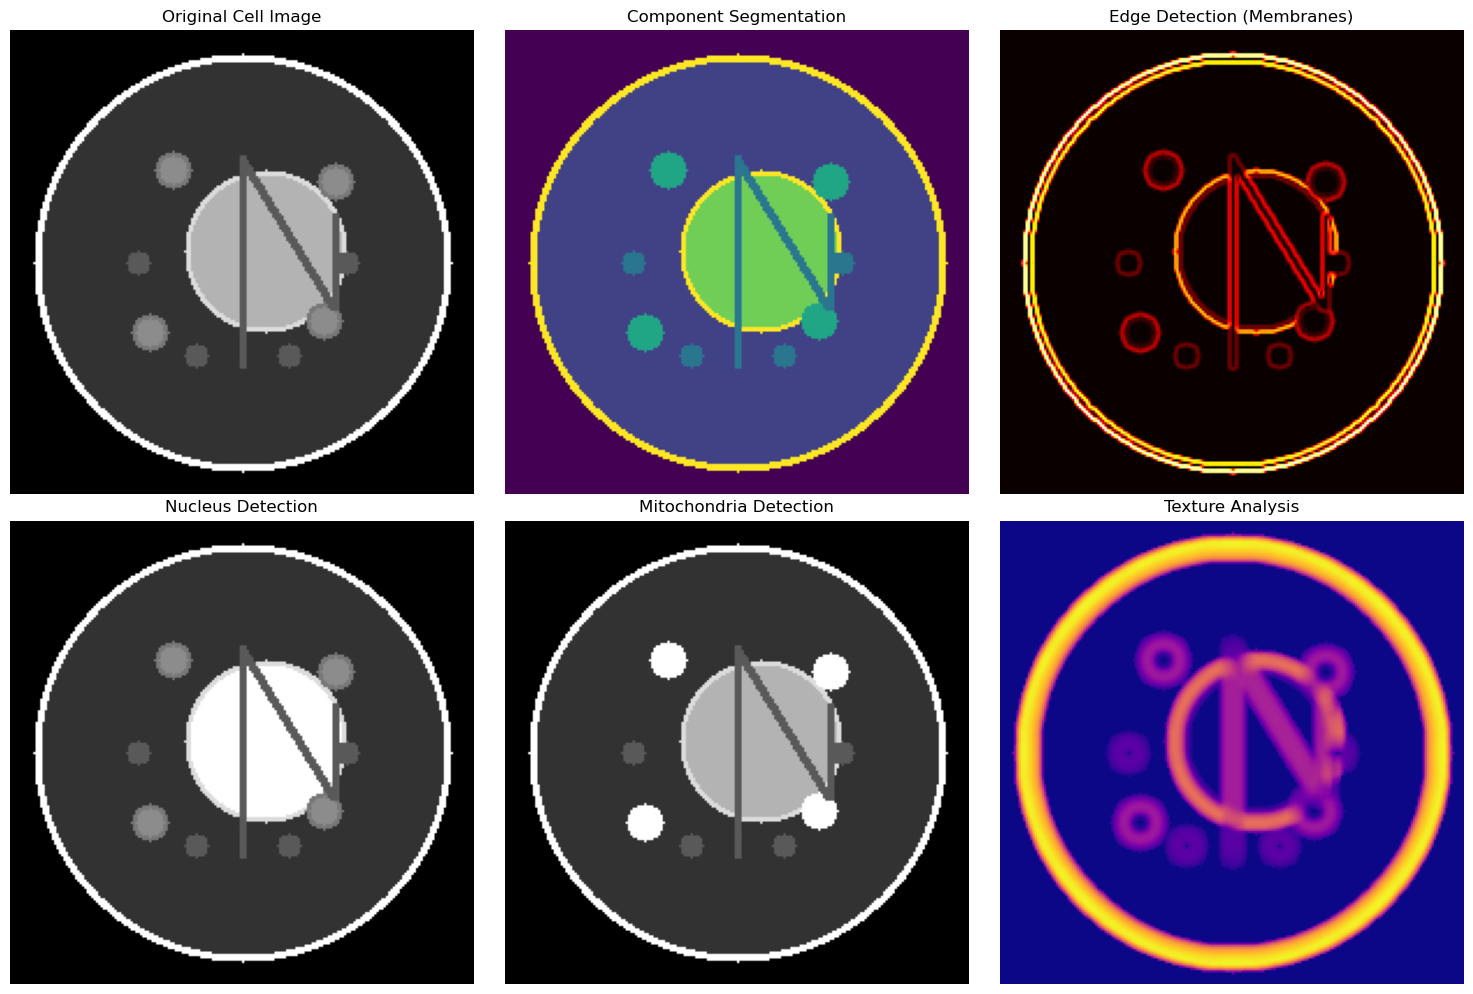


=== ANALYSIS COMPLETE ===
The analysis identified and characterized:
• Cell membrane and overall cell boundary
• Nuclear structure and location
• Mitochondrial count and distribution
• Endoplasmic reticulum network
• Membrane structures through edge detection
• Cellular texture patterns


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology, filters, segmentation
from scipy import ndimage

def create_cell_image(size=200):
    """
    Create a synthetic cell image with 4 features:
    1. Cell membrane (outer boundary)
    2. Nucleus (large central organelle)
    3. Mitochondria (smaller organelles)
    4. Endoplasmic reticulum (network-like structure)
    """
    # Initialize blank image
    image = np.zeros((size, size), dtype=np.uint8)
    
    # 1. Cell membrane (outer boundary)
    center = size // 2
    radius = size // 2 - 10
    y, x = np.ogrid[:size, :size]
    mask = (x - center)**2 + (y - center)**2 <= radius**2
    image[mask] = 50  # Background cytoplasm
    
    # Create membrane boundary
    membrane_mask = ((x - center)**2 + (y - center)**2 <= radius**2) & \
                   ((x - center)**2 + (y - center)**2 >= (radius-3)**2)
    image[membrane_mask] = 255  # Bright membrane
    
    # 2. Nucleus (large central organelle)
    nucleus_center_x, nucleus_center_y = center + 10, center - 5
    nucleus_radius = 35
    nucleus_mask = (x - nucleus_center_x)**2 + (y - nucleus_center_y)**2 <= nucleus_radius**2
    image[nucleus_mask] = 180  # Nucleus
    
    # Nuclear membrane
    nuclear_membrane = ((x - nucleus_center_x)**2 + (y - nucleus_center_y)**2 <= nucleus_radius**2) & \
                      ((x - nucleus_center_x)**2 + (y - nucleus_center_y)**2 >= (nucleus_radius-2)**2)
    image[nuclear_membrane] = 220
    
    # 3. Mitochondria (smaller organelles)
    # Add several mitochondria
    mito_positions = [(center-40, center+30), (center+35, center+25), 
                      (center-30, center-40), (center+40, center-35)]
    
    for mx, my in mito_positions:
        mito_mask = (x - mx)**2 + (y - my)**2 <= 8**2
        image[mito_mask] = 120  # Mitochondria
        # Mitochondrial cristae (internal structure)
        cristae_mask = (x - mx)**2 + (y - my)**2 <= 6**2
        image[cristae_mask] = 140
    
    # 4. Endoplasmic Reticulum (network-like structure)
    # Create ER as connected tubular structures
    er_points = [(center-20, center+40), (center+20, center+40), 
                 (center-45, center), (center+45, center)]
    
    for ex, ey in er_points:
        # Create small ER regions
        er_mask = (x - ex)**2 + (y - ey)**2 <= 5**2
        image[er_mask] = 90  # ER
    
    # Connect ER structures with lines
    rr, cc = np.meshgrid(range(size), range(size), indexing='ij')
    for i in range(len(er_points)-1):
        x1, y1 = er_points[i]
        x2, y2 = er_points[i+1]
        # Simple line drawing
        if abs(x2-x1) > abs(y2-y1):
            for px in range(min(x1,x2), max(x1,x2)):
                py = y1 + (y2-y1) * (px-x1) // (x2-x1) if x2 != x1 else y1
                if 0 <= px < size and 0 <= py < size:
                    for dx in range(-1, 2):
                        for dy in range(-1, 2):
                            if 0 <= px+dx < size and 0 <= py+dy < size:
                                image[px+dx, py+dy] = 90
    
    return image

def analyze_cell_image(image):
    """
    Analyze the cell image to identify and characterize different cellular components
    """
    print("=== CELL IMAGE ANALYSIS ===\n")
    
    # Basic image properties
    print(f"Image dimensions: {image.shape}")
    print(f"Pixel value range: {image.min()} - {image.max()}")
    print(f"Mean intensity: {image.mean():.2f}")
    print()
    
    # 1. Threshold-based segmentation to identify different components
    print("1. COMPONENT SEGMENTATION")
    print("-" * 30)
    
    # Define intensity thresholds for different organelles
    thresholds = {
        'Background': (0, 30),
        'Cytoplasm': (40, 60),
        'ER': (80, 100),
        'Mitochondria': (110, 150),
        'Nucleus': (170, 190),
        'Membranes': (200, 255)
    }
    
    component_masks = {}
    for component, (low, high) in thresholds.items():
        mask = (image >= low) & (image <= high)
        component_masks[component] = mask
        area = np.sum(mask)
        percentage = (area / image.size) * 100
        print(f"{component:12}: {area:5d} pixels ({percentage:5.2f}%)")
    
    print()
    
    # 2. Morphological analysis
    print("2. MORPHOLOGICAL ANALYSIS")
    print("-" * 30)
    
    # Analyze nucleus
    nucleus_mask = component_masks['Nucleus']
    if np.any(nucleus_mask):
        nucleus_props = measure.regionprops(nucleus_mask.astype(int))
        if nucleus_props:
            props = nucleus_props[0]
            print(f"Nucleus area: {props.area} pixels")
            print(f"Nucleus centroid: ({props.centroid[0]:.1f}, {props.centroid[1]:.1f})")
            print(f"Nucleus equivalent diameter: {props.equivalent_diameter:.2f} pixels")
    
    # Count mitochondria
    mito_mask = component_masks['Mitochondria']
    if np.any(mito_mask):
        # Clean up the mask and label connected components
        mito_cleaned = morphology.remove_small_objects(mito_mask, min_size=10)
        mito_labeled = measure.label(mito_cleaned)
        mito_props = measure.regionprops(mito_labeled)
        
        print(f"Number of mitochondria detected: {len(mito_props)}")
        total_mito_area = sum(prop.area for prop in mito_props)
        print(f"Total mitochondrial area: {total_mito_area} pixels")
        
        if mito_props:
            avg_mito_size = total_mito_area / len(mito_props)
            print(f"Average mitochondrial size: {avg_mito_size:.2f} pixels")
    
    print()
    
    # 3. Edge detection for membrane analysis
    print("3. MEMBRANE ANALYSIS")
    print("-" * 30)
    
    # Apply edge detection
    edges = filters.sobel(image)
    strong_edges = edges > np.percentile(edges, 90)  # Top 10% of edges
    
    print(f"Total edge pixels detected: {np.sum(strong_edges)}")
    
    # Identify circular structures (likely membranes)
    # Use Hough circle transform approximation
    edge_coords = np.column_stack(np.where(strong_edges))
    if len(edge_coords) > 0:
        center_y, center_x = image.shape[0]//2, image.shape[1]//2
        distances = np.sqrt((edge_coords[:, 0] - center_y)**2 + (edge_coords[:, 1] - center_x)**2)
        
        # Find the most common distance (likely cell membrane)
        hist, bins = np.histogram(distances, bins=20)
        most_common_distance = bins[np.argmax(hist)]
        print(f"Estimated cell radius: {most_common_distance:.2f} pixels")
    
    print()
    
    # 4. Texture analysis
    print("4. TEXTURE ANALYSIS")
    print("-" * 30)
    
    # Calculate local standard deviation (texture measure)
    footprint = morphology.disk(5)
    local_std = ndimage.generic_filter(image.astype(float), np.std, footprint=footprint)
    
    print(f"Average texture (local std): {local_std.mean():.2f}")
    print(f"Texture range: {local_std.min():.2f} - {local_std.max():.2f}")
    
    # Identify regions with high texture (likely ER or rough areas)
    high_texture = local_std > np.percentile(local_std, 80)
    print(f"High texture regions: {np.sum(high_texture)} pixels ({np.sum(high_texture)/image.size*100:.1f}%)")
    
    return component_masks, edges, local_std

def visualize_analysis(image, component_masks, edges, local_std):
    """
    Create visualization of the analysis results
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Original Cell Image')
    axes[0, 0].axis('off')
    
    # Component segmentation
    segmented = np.zeros_like(image)
    colors = [0, 50, 100, 150, 200, 255]
    for i, (component, mask) in enumerate(component_masks.items()):
        segmented[mask] = colors[i % len(colors)]
    
    axes[0, 1].imshow(segmented, cmap='viridis')
    axes[0, 1].set_title('Component Segmentation')
    axes[0, 1].axis('off')
    
    # Edge detection
    axes[0, 2].imshow(edges, cmap='hot')
    axes[0, 2].set_title('Edge Detection (Membranes)')
    axes[0, 2].axis('off')
    
    # Nucleus highlighting
    nucleus_highlight = image.copy()
    nucleus_highlight[component_masks['Nucleus']] = 255
    axes[1, 0].imshow(nucleus_highlight, cmap='gray')
    axes[1, 0].set_title('Nucleus Detection')
    axes[1, 0].axis('off')
    
    # Mitochondria highlighting
    mito_highlight = image.copy()
    mito_highlight[component_masks['Mitochondria']] = 255
    axes[1, 1].imshow(mito_highlight, cmap='gray')
    axes[1, 1].set_title('Mitochondria Detection')
    axes[1, 1].axis('off')
    
    # Texture analysis
    axes[1, 2].imshow(local_std, cmap='plasma')
    axes[1, 2].set_title('Texture Analysis')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Create synthetic cell image
    print("Creating synthetic cell image...")
    cell_image = create_cell_image(size=200)
    
    # Analyze the image
    component_masks, edges, local_std = analyze_cell_image(cell_image)
    
    # Visualize results
    print("\nGenerating visualization...")
    visualize_analysis(cell_image, component_masks, edges, local_std)
    
    print("\n=== ANALYSIS COMPLETE ===")
    print("The analysis identified and characterized:")
    print("• Cell membrane and overall cell boundary")
    print("• Nuclear structure and location") 
    print("• Mitochondrial count and distribution")
    print("• Endoplasmic reticulum network")
    print("• Membrane structures through edge detection")
    print("• Cellular texture patterns")